In [1]:
from shapely.geometry import box, Point, LineString
import pyrosm
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy import stats
import geopandas
import pandas as pd
import numpy as np
import random
import networkx as nx
import math
from rasterio.crs import CRS
from sys import getsizeof

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 2000
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [3]:
# convenience function for printing
def print_size(obj, suffix='B'):
    num = getsizeof(obj)
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    print("%.1f%s%s" % (num, 'Yi', suffix))

In [4]:
%%time
import pickle
from pathlib import Path

class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
    
households_gdf = pickle.loads(Path('pickles/greater_manchester/households_gdf').read_bytes())
people = pickle.loads(Path('pickles/greater_manchester/people_list').read_bytes())
trimmed_work = pickle.loads(Path('pickles/greater_manchester/workplaces_gdf').read_bytes())
boundary = pickle.loads(Path('pickles/greater_manchester/boundary').read_bytes())

CPU times: user 4.17 s, sys: 766 ms, total: 4.94 s
Wall time: 4.93 s


<AxesSubplot:>

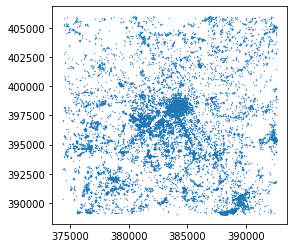

In [84]:
trimmed_work = trimmed_work.to_crs(OUT_CRS)
trimmed_work.plot(markersize=0.1)

In [6]:
%%time
# get all public transport
full_edges = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/edges.csv')
full_nodes = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
full_nodes = geopandas.GeoDataFrame(full_nodes, geometry=geopandas.points_from_xy(full_nodes.lon, full_nodes.lat), crs="EPSG:4326")
layers = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
nodes = geopandas.clip(full_nodes, boundary)
# Only select edges that start or end at the clipped nodes
des_edges = full_edges[full_edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
ori_edges = full_edges[full_edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
unclipped_edges = des_edges.merge(ori_edges) # inner merge to get edges that start and end in the boundary

CPU times: user 2.55 s, sys: 297 ms, total: 2.84 s
Wall time: 2.85 s


In [7]:
%%time
# Draw lines for the edges
old_index = full_nodes.index
full_nodes = full_nodes.set_index(['node', 'layer'])
unclipped_edges = geopandas.GeoDataFrame(unclipped_edges, geometry=unclipped_edges.apply(lambda x: LineString([
    full_nodes.loc[(x.ori_node, x.ori_layer)].geometry, 
    full_nodes.loc[(x.des_node, x.des_layer)].geometry
]), axis=1))
full_nodes = full_nodes.reset_index()
full_nodes.index = old_index

# commented for now as we require des AND ori nodes to be within the boundary instead of OR
# Clip those edges to the boundary too
# edges = geopandas.clip(unclipped_edges.reset_index(), boundary)  
# Get rid of empty geometries
#edges = edges[~edges.is_empty]
edges = unclipped_edges

CPU times: user 4.03 s, sys: 0 ns, total: 4.03 s
Wall time: 4.04 s


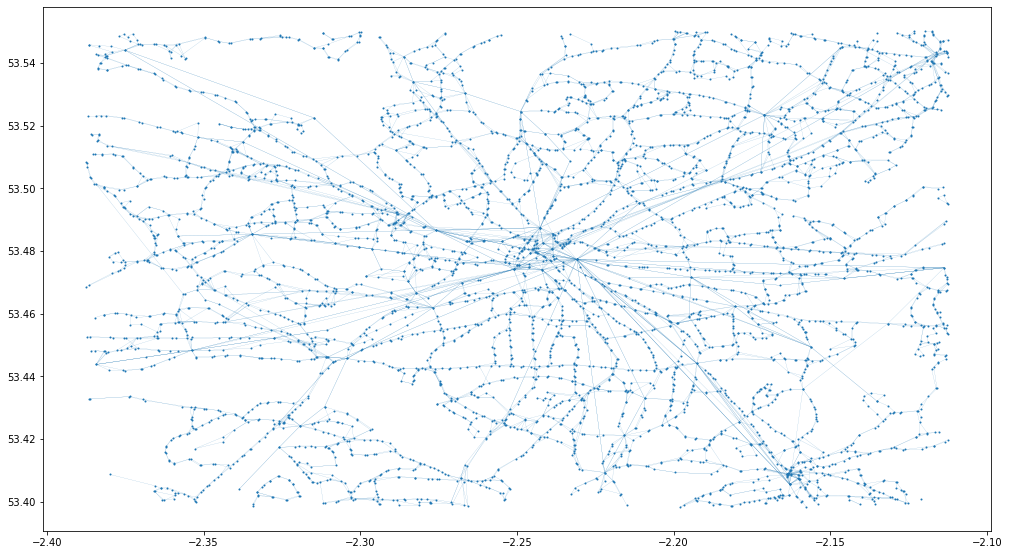

In [8]:
fig, ax = plt.subplots(figsize=(17, 17))
nodes.plot(ax=ax, markersize=1)
edges.plot(ax=ax, linewidth=0.1)
del fig, ax

In [9]:
nodes['osmid'] = nodes['node'].astype(str) + '_' + nodes['layer'].astype(str)
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
nodes.set_index('osmid', verify_integrity=True, inplace=True, drop=False) # keep the column as osmnx needs it (as well as it being the index of the DF)
nodes

,node,layer,lat,lon,zone,atcocode,geometry,osmid,x,y
osmid,,,,,,,,,,
1593_3,1593,3,53.47437,-2.29338,940,940GZZMAHCY,POINT (-2.29338 53.47437),1593_3,-2.29338,53.47437
2537_5,2537,5,53.46995,-2.26761,940,9400ZZMACRN,POINT (-2.26761 53.46995),2537_5,-2.26761,53.46995
2537_3,2537,3,53.46995,-2.26761,940,9400ZZMACRN,POINT (-2.26761 53.46995),2537_3,-2.26761,53.46995
3122_2,3122,2,53.43308,-2.20925,910,910GMLDTHRD,POINT (-2.20925 53.43308),3122_2,-2.20925,53.43308
3122_5,3122,5,53.43308,-2.20925,910,910GMLDTHRD,POINT (-2.20925 53.43308),3122_5,-2.20925,53.43308
...,...,...,...,...,...,...,...,...,...,...
262016_5,262016,5,53.48001,-2.25264,180,1800SB10121,POINT (-2.25264 53.48001),262016_5,-2.25264,53.48001
262165_5,262165,5,53.43478,-2.18959,180,1800SG14321,POINT (-2.18959 53.43478),262165_5,-2.18959,53.43478
262203_5,262203,5,53.49617,-2.12599,180,1800EH36201,POINT (-2.12599 53.49617),262203_5,-2.12599,53.49617


In [10]:
edges['u'] = edges['ori_node'].astype(str) + '_' + edges['ori_layer'].astype(str)
edges['v'] = edges['des_node'].astype(str) + '_' + edges['des_layer'].astype(str)
edges['key'] = edges.reset_index()['index']
edges['osmid'] = edges['u'].astype(str) + '_' + edges['v'].astype(str)
edges.set_index(['u', 'v', 'key'], inplace=True)
edges = edges.set_crs("EPSG:4326")
edges

ori_node  des_node  ori_layer  des_layer  minutes  \
u        v        key                                                       
3122_2   14170_2  0         3122     14170          2          2        8   
         35268_2  1         3122     35268          2          2        2   
7446_2   32923_2  2         7446     32923          2          2        4   
         34325_2  3         7446     34325          2          2       10   
7562_2   35310_2  4         7562     35310          2          2        5   
...                          ...       ...        ...        ...      ...   
153298_5 153298_4 6207    153298    153298          5          4        1   
162599_4 162599_5 6208    162599    162599          4          5        1   
162599_5 162599_4 6209    162599    162599          5          4        1   
258106_4 258106_5 6210    258106    258106          4          5        1   
258106_5 258106_4 6211    258106    258106          5          4        1   

                           km  \
u        v        key           
3122_2   14170_2  0     5.121   
         35268_2  1     1.386   
7446_2   32923_2  2     4.652   
         34325_2  3     9.157   
7562_2   35310_2  4     2.935   
...                       ...   
153298_5 153298_4 6207  0.000   
162599_4 162599_5 6208  0.000   
162599_5 162599_4 6209  0.000   
258106_4 258106_5 6210  0.000   
258106_5 258106_4 6211  0.000   

                                                                 geometry  \
u        v        key                                                       
3122_2   14170_2  0     LINESTRING (-2.20925 53.43308, -2.23091 53.47737)   
         35268_2  1     LINESTRING (-2.20925 53.43308, -2.21568 53.42119)   
7446_2   32923_2  2     LINESTRING (-2.37512 53.54415, -2.31475 53.52250)   
         34325_2  3     LINESTRING (-2.37512 53.54415, -2.27575 53.48660)   
7562_2   35310_2  4     LINESTRING (-2.15876 53.43594, -2.13166 53.45688)   
...                                                                   ...   
153298_5 153298_4 6207  LINESTRING (-2.14637 53.54517, -2.14637 53.54517)   
162599_4 162599_5 6208  LINESTRING (-2.25382 53.47643, -2.25382 53.47643)   
162599_5 162599_4 6209  LINESTRING (-2.25382 53.47643, -2.25382 53.47643)   
258106_4 258106_5 6210  LINESTRING (-2.24993 53.47568, -2.24993 53.47568)   
258106_5 258106_4 6211  LINESTRING (-2.24993 53.47568, -2.24993 53.47568)   

                                    osmid  
u        v        key                      
3122_2   14170_2  0        3122_2_14170_2  
         35268_2  1        3122_2_35268_2  
7446_2   32923_2  2        7446_2_32923_2  
         34325_2  3        7446_2_34325_2  
7562_2   35310_2  4        7562_2_35310_2  
...                                   ...  
153298_5 153298_4 6207  153298_5_153298_4  
162599_4 162599_5 6208  162599_4_162599_5  
162599_5 162599_4 6209  162599_5_162599_4  
258106_4 258106_5 6210  258106_4_258106_5  
258106_5 258106_4 6211  258106_5_258106_4  

[6212 rows x 8 columns]

In [11]:
import osmnx
graph = osmnx.utils_graph.graph_from_gdfs(nodes, edges, None)

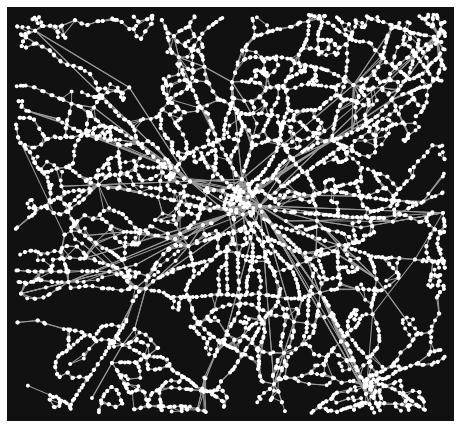

In [12]:
fig, ax = osmnx.plot_graph(graph)

In [13]:
osmnx.utils_graph.graph_to_gdfs(graph, nodes=False)

ori_node  des_node  ori_layer  des_layer  minutes  \
u        v        key                                                       
3122_2   14170_2  0         3122     14170          2          2        8   
         35268_2  1         3122     35268          2          2        2   
         3122_5   6054      3122      3122          2          5        2   
14170_2  3122_2   18       14170      3122          2          2        7   
         12413_2  19       14170     12413          2          2        8   
...                          ...       ...        ...        ...      ...   
256806_5 204093_5 5918    256806    204093          5          5        1   
         246963_5 5919    256806    246963          5          5        1   
257328_5 193889_5 5933    257328    193889          5          5        1   
259178_5 77294_5  5965    259178     77294          5          5        1   
261996_5 55027_5  6046    261996     55027          5          5        1   

                           km  \
u        v        key           
3122_2   14170_2  0     5.121   
         35268_2  1     1.386   
         3122_5   6054  0.133   
14170_2  3122_2   18    5.121   
         12413_2  19    7.749   
...                       ...   
256806_5 204093_5 5918  0.236   
         246963_5 5919  0.331   
257328_5 193889_5 5933  0.433   
259178_5 77294_5  5965  0.348   
261996_5 55027_5  6046  0.114   

                                                                 geometry  \
u        v        key                                                       
3122_2   14170_2  0     LINESTRING (-2.20925 53.43308, -2.23091 53.47737)   
         35268_2  1     LINESTRING (-2.20925 53.43308, -2.21568 53.42119)   
         3122_5   6054  LINESTRING (-2.20925 53.43308, -2.20925 53.43308)   
14170_2  3122_2   18    LINESTRING (-2.23091 53.47737, -2.20925 53.43308)   
         12413_2  19    LINESTRING (-2.23091 53.47737, -2.11371 53.47465)   
...                                                                   ...   
256806_5 204093_5 5918  LINESTRING (-2.35270 53.40030, -2.35486 53.40200)   
         246963_5 5919  LINESTRING (-2.35270 53.40030, -2.35096 53.40310)   
257328_5 193889_5 5933  LINESTRING (-2.11356 53.53716, -2.11746 53.54030)   
259178_5 77294_5  5965  LINESTRING (-2.25234 53.45477, -2.25212 53.45163)   
261996_5 55027_5  6046  LINESTRING (-2.18373 53.43576, -2.18527 53.43528)   

                                    osmid  
u        v        key                      
3122_2   14170_2  0        3122_2_14170_2  
         35268_2  1        3122_2_35268_2  
         3122_5   6054      3122_2_3122_5  
14170_2  3122_2   18       14170_2_3122_2  
         12413_2  19      14170_2_12413_2  
...                                   ...  
256806_5 204093_5 5918  256806_5_204093_5  
         246963_5 5919  256806_5_246963_5  
257328_5 193889_5 5933  257328_5_193889_5  
259178_5 77294_5  5965   259178_5_77294_5  
261996_5 55027_5  6046   261996_5_55027_5  

[6212 rows x 8 columns]

In [14]:
%%time
transit_node_positions = [tuple(coord) for coord in nodes[['x', 'y']].to_numpy()]
nodeKdTree = cKDTree(data=transit_node_positions)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 10.1 ms


In [ ]:
# %%time
# amount = 10_000
# print(f'For {amount} iterations')
# for index, person in enumerate(people):
#     if index > amount:
#         break
#     osmnx.distance.get_nearest_node(graph, person.pos)

In [ ]:
# %%time
# print(f'For {len(people)} iterations')
# for index, person in enumerate(people):
#     nodeKdTree.query(x=person.pos, k=1)

In [15]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [16]:
%%time
work_nearest_nodes = cKDQueryRadius(trimmed_work, nodes, radius=1_500, workers=5)
print_size(work_nearest_nodes)

CPU times: user 2.59 s, sys: 344 ms, total: 2.94 s
Wall time: 2.68 s


'19.4MiB'

In [17]:
%%time
nodes_nearest_households = cKDQueryRadius(nodes, households_gdf, radius=1_500, workers=5)
print_size(nodes_nearest_households)

CPU times: user 51.5 s, sys: 3.88 s, total: 55.4 s
Wall time: 52.2 s


'463.7MiB'

In [18]:
%%time
len_path = dict(nx.all_pairs_dijkstra(graph, cutoff=90, weight='minutes'))  # {node_num: ( {target_num: dist_num}, {target_num: [...path_elements]} ) }

CPU times: user 1min 21s, sys: 21.6 s, total: 1min 43s
Wall time: 1min 43s


In [23]:
# %%time
# household_positions = list(households_gdf.geometry.centroid.apply(lambda x: (x.x, x.y)))
# households_kd_tree = cKDTree(data=household_positions)
# print_size(households_kd_tree) doesn't work

In [24]:
# %%time
# workplace_positions = [(x, y) for x, y in zip(trimmed_work.geometry.x, trimmed_work.geometry.y)]

In [25]:
# %%time
# for pos in workplace_positions:
#     households_kd_tree.query_ball_point(pos, 500)

In [22]:
households_gdf

,uid,inhabitants,geometry
0,0,3,POINT (374471.444 405740.925)
1,1,2,POINT (374476.123 405898.300)
2,2,2,POINT (374419.472 405768.301)
3,3,3,POINT (374444.935 405773.723)
4,4,4,POINT (374440.272 405770.164)
...,...,...,...
535063,535063,2,POINT (392210.621 389322.477)
535064,535064,2,POINT (392210.621 389322.477)
535065,535065,2,POINT (392210.621 389322.477)
535066,535066,3,POINT (392210.621 389322.477)


In [26]:
people_df = pd.DataFrame(data=[{'uid': person.uid, 'x': person.pos[0], 'y': person.pos[1], 'age': person.age} for person in people])
print_size(people_df)

'31.5MiB'

<AxesSubplot:>

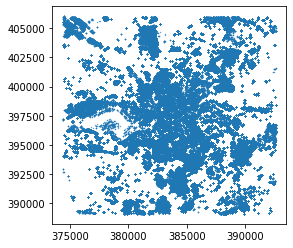

In [106]:
# people_gdf = geopandas.GeoDataFrame(people_df, geometry=geopandas.points_from_xy(people_df.x, people_df.y), crs=OUT_CRS)
# fig, ax = plt.subplots(figsize=(10,10))
# people_gdf.plot(ax=ax, marker_size=0.1)
# del fig, ax, test, people_gdf

In [27]:
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(OUT_CRS)
bounds = projected_boundary.bounds
boundary_minx = bounds.loc[bounds.index[0], 'minx']
boundary_maxx = bounds.loc[bounds.index[0], 'maxx']
boundary_miny = bounds.loc[bounds.index[0], 'miny']
boundary_maxy = bounds.loc[bounds.index[0], 'maxy']

In [28]:
bucket_size = 500 # meters for OUT_CRS
y_len = int(math.ceil((boundary_maxy - boundary_miny) / bucket_size))
x_len = int(math.ceil((boundary_maxx - boundary_minx) / bucket_size))

print(f'y: {y_len}, x: {x_len}')

y: 34, x: 37


In [85]:
unemployed = people_df.loc[(17 <= people_df['age']) & (people_df['age'] <= 67)].copy()
print(len(unemployed))

482030


In [86]:
unemployed['bucket_x'] = np.ceil(((unemployed['x'] - boundary_minx) / bucket_size) - 1).astype(int)
unemployed['bucket_y'] = np.ceil(((unemployed['y'] - boundary_miny) / bucket_size) - 1).astype(int)

In [87]:
# unemployed_bucket = np.array([[]] * (y_len * x_len) + [[1]], dtype=object)[:-1].reshape((y_len, x_len))

In [88]:
def make_buckets():
    unemployed_bucket = [[[] for x in range(x_len)] for y in range(y_len)]
    for person in unemployed.itertuples():
        unemployed_bucket[person.bucket_y][person.bucket_x].append(person.uid)
    
    return unemployed_bucket

In [89]:
%%time
unemployed_bucket = make_buckets()

CPU times: user 578 ms, sys: 31.2 ms, total: 609 ms
Wall time: 592 ms


In [74]:
len(unemployed_bucket)

34

In [90]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, centre_y=None, centre_x=None, radius=None):
    if centre_x is None: # use the middle of the image
        centre_x = int(w / 2)
    if centre_y is None:
        centre_y = int(h / 2)
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(centre_y, centre_x, (w - centre_x), (h - centre_y))

    y, x = np.ogrid[-centre_y:(h - centre_y), -centre_x:(w - centre_x)]
    mask = (x * x) + (y * y) <= (radius * radius)
    return mask

In [91]:
%%time
counts = np.array([list(map(len, row)) for row in unemployed_bucket])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 195 µs


In [92]:
%%time
mask = create_circular_mask(h=y_len, w=x_len)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 102 µs


In [93]:
indices = np.argwhere(mask)
indices.shape

(900, 2)

In [94]:
%%time
probabilities = counts[mask] / np.sum(counts[mask])
probabilities.size

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 264 µs


900

In [95]:
%%timeit
chosen_buckets = np.random.choice(np.arange(indices.shape[0]), 1_000, p=probabilities)

115 µs ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


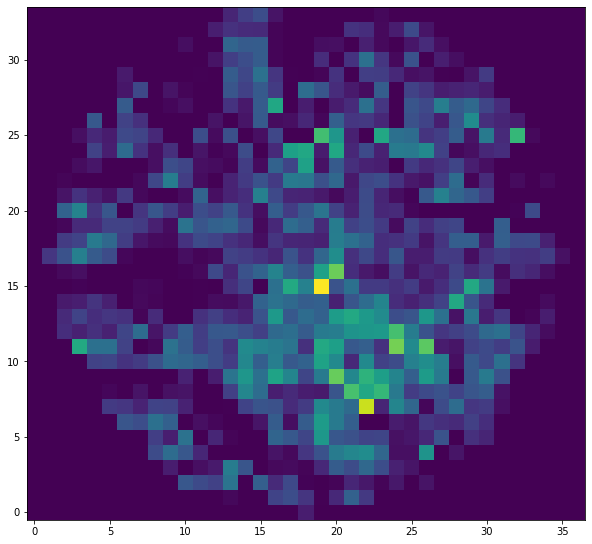

In [96]:
# sanity check the sampling matches the underlying probabilities
chosen_buckets = np.random.choice(np.arange(indices.shape[0]), 50_000, p=probabilities)

test = np.zeros(counts.shape)
for index, chosen in enumerate(chosen_buckets):
    test[tuple(indices[chosen])] += 1
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test, origin='lower')
del fig, ax, test, chosen_buckets

In [97]:
def valid_unemployed_within_dist(y, x, dist, cache_size=200):
    counts = np.array([list(map(len, row)) for row in unemployed_bucket])
    y = (int(math.ceil((boundary_maxy - y) / bucket_size)))
    x = (int(math.ceil((boundary_maxx - x) / bucket_size)))
    dist = dist / bucket_size
    mask = create_circular_mask(h=y_len, w=x_len, centre_y=y, centre_x=x, radius=dist)
    
    indices = np.argwhere(mask)
    if np.sum(counts[mask]) == 0:
        raise Exception('No viable unemployed people left')
    probabilities = counts[mask] / np.sum(counts[mask])
#     print(f'x: {x}, y: {y}, indices: {indices}, probabilities: {probabilities}')
    
    chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities) # a cache of sampled choices
    chosen_iter = iter(chosen_buckets)
    failures = 0
    
    while True:
        try:
            next_bucket_pos = tuple(indices[next(chosen_iter)])
        except StopIteration: # used up the cache, repopulate with some more random choices
            chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
            chosen_iter = iter(chosen_buckets)
            continue
        try: 
            next_person = unemployed_bucket[next_bucket_pos[0]][next_bucket_pos[1]].pop()
        except IndexError: # no unemployed people in that bucket
            failures += 1
            if failures > 300: # we had a lot of failures, recalc the probability map
                failures = 0
                
                counts = np.array([list(map(len, row)) for row in unemployed_bucket])
                
                total_unemployed_left = np.sum(counts[mask])
                if total_unemployed_left == 0:
                    raise Exception('No viable unemployed people left')
                
                probabilities = counts[mask] / total_unemployed_left
                
                if np.isnan(probabilities).any():
                    print(f"THE FUCK, unemployed: {total_unemployed_left}, counts: {counts[mask]}")
                
                chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
                chosen_iter = iter(chosen_buckets)
            continue
            
        yield next_person

In [100]:
unemployed_bucket = make_buckets()
(y, x) = (trimmed_work.loc[len(trimmed_work) // 3].geometry.y, trimmed_work.loc[len(trimmed_work) // 3].geometry.x)
valid_unemployed_gen_5k = valid_unemployed_within_dist(y, x, 5_000)

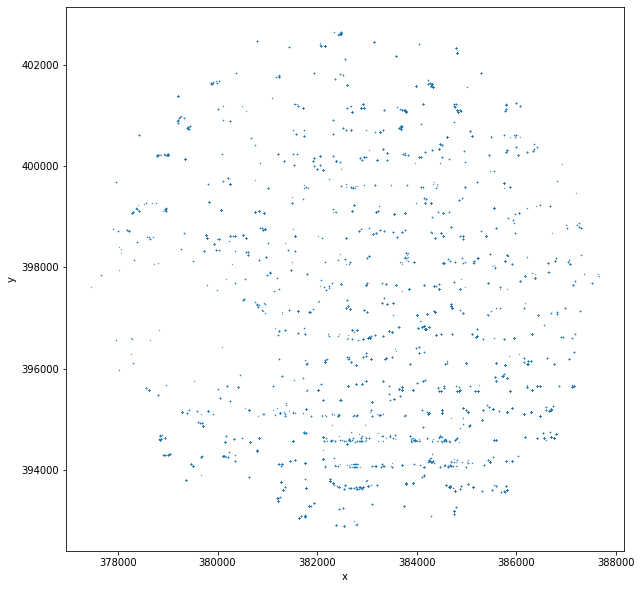

In [101]:
# sanity check the sampling matches the underlying probabilities
chosen_people = [(next(valid_unemployed_gen_5k)) for i in range(10_000)]

fig, ax = plt.subplots(figsize=(10,10))
# sanity check
people_df.loc[chosen_people].plot(ax=ax, x='x', y='y', kind='scatter', s=0.1)
del fig, ax, chosen_people

In [ ]:
%%timeit -r 10 -n 20_000
next(valid_unemployed_gen_5k)

In [ ]:
# households within 60k
# generate a probability heatmap
# ravel and sample it
# if there are no free slots set it to 0
# if 100 misses in a row, regenerate probability map

In [ ]:
# pick a random vector
# query-ball around that vector
# try X vectors, then new dist

In [102]:
from enum import Enum
class TransportType(Enum):
    PUBLIC_TRANSIT = 0,
    DRIVING = 1,
    CYCLING = 2,
    WALKING = 3

In [103]:
%%time
unemployed_bucket = make_buckets()
to_allocate = len(unemployed)
print(f'Trying to allocate {to_allocate} people, {len(trimmed_work)} workplaces')
people_to_workplaces = [None] * len(people_df)
failures = 0
exceptions = set()
successes = 0
for index, workplace in enumerate(trimmed_work.sample(frac=1).itertuples()): # iterate over shuffled workplaces
#     if index >= 1_000:
#         break
    if successes >= to_allocate:
        print(f'Allocated all at workplace: {index}')
        break
    valid_unemployed_gen_60k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 60_000)
    valid_unemployed_gen_20k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 20_000)
    valid_unemployed_gen_5k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 5_000)
    
    for _ in range(workplace.capacity):
        # TODO update to better reflect real distributions if possible, maybe weight it by workplace size, more likely to walk if you own the business
        transport = random.choice([TransportType.PUBLIC_TRANSIT, TransportType.DRIVING, TransportType.CYCLING, TransportType.WALKING])
        
        person_id = None
        try:
            if transport == TransportType.PUBLIC_TRANSIT:
                continue
            elif transport == TransportType.DRIVING:
                person_id = next(valid_unemployed_gen_60k)
            elif transport == TransportType.CYCLING:
                person_id = next(valid_unemployed_gen_20k)
            elif transport == TransportType.WALKING:
                person_id = next(valid_unemployed_gen_5k)
        except Exception as e:
            exceptions.add(repr(e)) # TODO, StopIteration appears on a generator *after* an Exception has already occurred on it, cleanup
            failures +=1
            
            try: 
                person_id = next(valid_unemployed_gen_60k)
            except Exception as e:
                exceptions.add(repr(e))
                failures +=1
                continue
            
        people_to_workplaces[person_id] = workplace.index
        successes += 1
        if successes >= to_allocate:
            break
            
    
    # workplace_row.capacity
    # workplace.index    
    
print(f'Successes: {successes}, Failures: {failures}, Exceptions: {exceptions}')

Trying to allocate 482030 people, 19270 workplaces
Allocated all at workplace: 3017
Successes: 482030, Failures: 3463, Exceptions: {"Exception('No viable unemployed people left')", 'StopIteration()'}
CPU times: user 5.64 s, sys: 46.9 ms, total: 5.69 s
Wall time: 5.69 s


In [ ]:
# could maybe make a list of positions attached to workplaces, sort by location and then shuffle half?
# TODO investigate if marking all POIs is way too optimistic

In [ ]:
%%time
fp = pyrosm.get_data("London", update=True)
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [ ]:
%%time
walk_net = osm.get_network(network_type="walking")
bike_net = osm.get_network(network_type="cycling")
drive_net = osm.get_network(network_type="driving+service")

In [ ]:
%%time
walk_net.plot()
bike_net.plot()
drive_net.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
walk_net.plot(ax=ax, linewidth=0.3)
clipped_nodes.plot(ax=ax, markersize=1, color="red")
clipped_new_edges[~clipped_new_edges.is_empty].plot(ax=ax, linewidth=0.1, color="red")

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def _get_commute_dist():
    mean = 30.0
    std_dev = 7.0
    size = 100_000
    distances = np.random.normal(mean, std_dev, size)  # TODO Update this to reflect actual distribution from research
    distance_iter = iter(distances)
    
    while True:
        if next(distance_iter, None) is None:
            distances = np.random.normal(mean, std_dev, size)  # refresh the distances
            distance_iter = iter(distances)
        yield next(distance_iter)

In [ ]:
commute_dist_gen = _get_commute_dist()
distances = list()
for i in range(20):
    distances.append(next(commute_dist_gen))